# Model for the kex mesh of the gate

We'll use an availabel package to do the main hex mesh, __hexalattice__, and work from it to select the region covered and the (simplified) focusing effect.

In [2]:
from hexalattice.hexalattice import create_hex_grid
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

#### Simple example of package

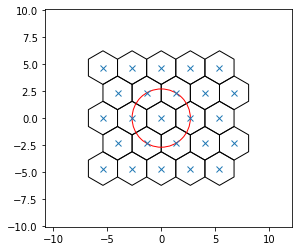

In [9]:
fig, ax = plt.subplots(1,1)
a = 1.56
r = a * np.sqrt(3)
hex_centers, _ = create_hex_grid(nx=5, ny=5, min_diam = r, h_ax =ax, do_plot = True)
c = Circle((0,0), r, fill = False, color = 'red')
ax.add_patch(c)
ax.plot(hex_centers[:, 0], hex_centers[:,1], marker = 'x', ls = '')

plt.show()

#### Creating the gate

In [3]:
# how many hexagon we need?
r_max = 75
a = 1.56
r_hex = a * np.sqrt(3)

n_hex_x = 2 * np.ceil(75/r_hex)
n_hex_y = 2 * np.ceil(75/(np.sqrt(2)*a))

In [4]:
r_hex

2.7019992598074487

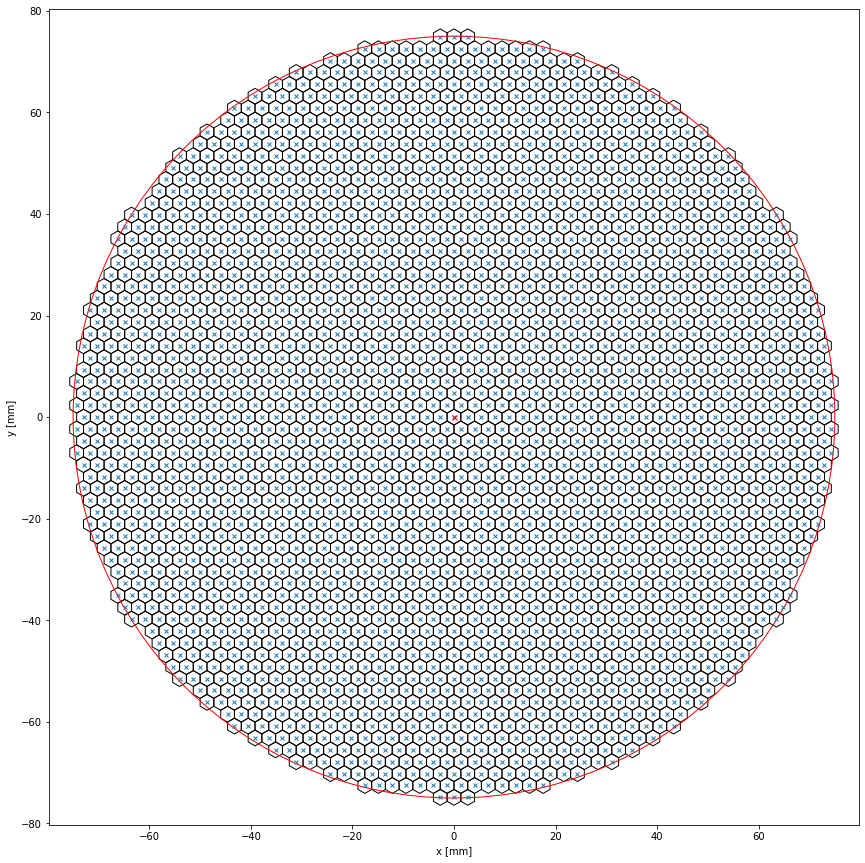

In [187]:
fig, ax = plt.subplots(1,1, figsize = (15,15))

hex_centers, _ = create_hex_grid(nx=n_hex_x, ny=n_hex_y, 
                                 min_diam = r_hex,crop_circ = r_max,
                                 h_ax =ax, do_plot = True)
c = Circle((0,0), r_max, fill = False, color = 'red')
ax.add_patch(c)

hex_origin_dist = np.sqrt(np.power(hex_centers[:,0],2)+np.power(hex_centers[:,1],2))
mask_r = hex_origin_dist < r_max
hex_centers_inside = hex_centers[mask_r]

ax.plot(hex_centers_inside[:, 0], hex_centers_inside[:,1], marker = 'x', ls = '', ms = 4)
plt.plot(0,0,marker = 'x', color = 'r', ms = 5)
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
plt.savefig('figures/hex_mesh_grid.png')
plt.show()

In [34]:
hex_centers.shape

(2791, 2)

#### Focusing effect

In [181]:
def distance_to_reference_grid(hex_centers,pos_xy):
    '''
    Given an array of reference positions (hex grid in this partivular case) - format 
    [[xs,ys]] -, return the distance of a point (x0,y0) to these reference points.
    '''
    hex_distance = np.sqrt(np.power(hex_centers[:,0]-pos_xy[0],2) + 
                           np.power(hex_centers[:,1]-pos_xy[1],2)
                          )
    return hex_distance
                            
def get_closest_hex(pos_xy):
    '''
    Given a reference grid and a point on the plane, return the grid index where 
    the point is closeste to a grid point.
    '''
    distances = distance_to_reference_grid(hex_centers,pos_xy)
    idx_min_dist = np.argmin(distances)
    return hex_centers[idx_min_dist]

def focus_on_grid(pos_array):
    '''
    Focuses the electrons to the center of the hexagons. `pos_array` must
    be of the shape (N, 2), where pos_array[:,0] are x values and 
    pos_array[:,1] are y values.
    Returns a (N,2) array of the positions after the focus effect.
    '''
    pos_focus = np.apply_along_axis(get_closest_hex, 1, pos_array)
    return pos_focus
    

In [183]:
beep = (5,0)
boop = get_closest_hex(beep)

print('Initial coor: %s\nfocused coor: %s.' %(beep, boop))

Initial coor: (5, 0)
focused coor: [5.40399852 0.        ].


In [184]:
n_samples = 1000
thetas = np.random.uniform(0,2*np.pi, size = (n_samples))
r = np.random.uniform(0,10, size = (n_samples))
x = r*np.cos(thetas)
y = r*np.sin(thetas)
pos =  np.stack((x, y), axis=1)

pos_focus = focus_on_grid(pos)

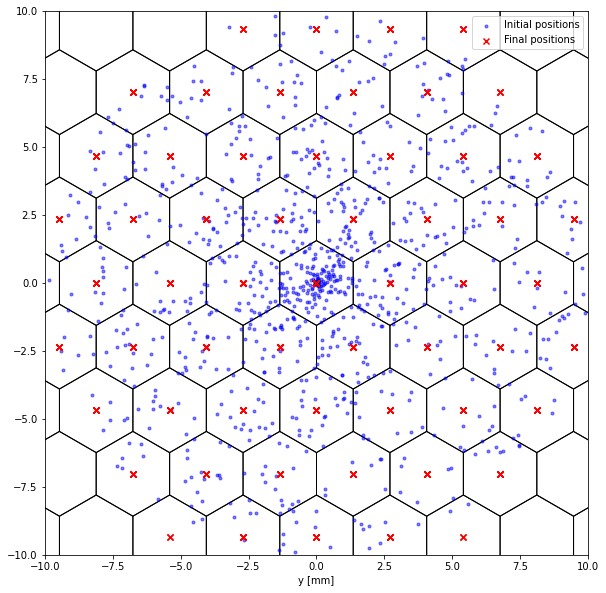

In [188]:
fig, ax = plt.subplots(1,1, figsize = (10,10))

hex_centers, h_ax = create_hex_grid(nx=n_hex_x, ny=n_hex_y, 
                                    min_diam = r_hex,crop_circ = r_max,
                                    h_ax =ax, do_plot = True)

# ax.plot(hex_centers[:, 0], hex_centers[:,1], 
#         c = 'k',ls = '',marker = 'o', ms = 15, 
#         markerfacecolor = 'none', label = 'Mesh centers')

ax.scatter(pos[:,0], pos[:,1], marker = '.',c = 'b', label = 'Initial positions', alpha = 0.5)
ax.scatter(pos_focus[:,0], pos_focus[:,1], c = 'r',marker = 'x', label = 'Final positions')

ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_xlabel('x [mm]')
ax.set_xlabel('y [mm]')
plt.gca().set_aspect('equal')
plt.legend()
plt.savefig('figures/focusing_effect.png')
plt.show()